In [1]:
from config import N, A, b, l, u, M, COV_MATRIX, RISK_F, RISK_ABS, SINGLE_ABS, L1_ABS, SIGMA_ABS
from model_factory import build_market_neutral_model
model = build_market_neutral_model(N, A, b, l, u, RISK_F, RISK_ABS, SINGLE_ABS, L1_ABS, COV_MATRIX, SIGMA_ABS)

Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Restricted license - for non-production use only - expires 2026-11-23


In [2]:
from config import DATASET_DICT_PATH
from io_utils import load_dataset_dict, create_dataset_from_dict
dataset_dict = load_dataset_dict(DATASET_DICT_PATH)
dataset = create_dataset_from_dict(dataset_dict, model)

/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [3]:
from config import K, HIDDEN_DIM, LSTM_HIDDEN_DIM, DROPOUT_RATE, DEVICE
from architecture import TwoLayerLSTM
lstm = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: 0.002329249633476138 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: 0.0006990240653976798 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.006766781210899353 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.004031309392303228 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([64]) | Parameters: 

In [4]:
from sklearn.model_selection import train_test_split
from data_loader import get_data_loaders, device_loader
# 创建 Subset 类
from torch.utils.data import Subset

indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
dataset_train = Subset(dataset, train_indices)
dataset_test = Subset(dataset, test_indices)
loader_train, loader_test = get_data_loaders(dataset_train, dataset_test)

In [5]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR        # Adjusted learning rate
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_13_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Num of cores: 1


/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Initial regret: 37.4746%


Epoch 1/5: 100%|██████████| 13101/13101 [05:09<00:00, 42.32it/s, loss=0.0033, batch time=0.0200s]


Epoch 1: Loss=0.005143, Regret=37.7054%, Time=347.79s


Epoch 2/5: 100%|██████████| 13101/13101 [05:07<00:00, 42.59it/s, loss=0.0056, batch time=0.0201s]


Epoch 2: Loss=0.004560, Regret=37.6828%, Time=343.93s


Epoch 3/5: 100%|██████████| 13101/13101 [05:07<00:00, 42.59it/s, loss=0.0049, batch time=0.0201s]


Epoch 3: Loss=0.004559, Regret=37.6886%, Time=343.86s


Epoch 4/5: 100%|██████████| 13101/13101 [05:08<00:00, 42.49it/s, loss=0.0035, batch time=0.0201s]


Epoch 4: Loss=0.004558, Regret=37.6881%, Time=344.67s


Epoch 5/5: 100%|██████████| 13101/13101 [05:08<00:00, 42.43it/s, loss=0.0064, batch time=0.0199s]


Epoch 5: Loss=0.004558, Regret=37.6818%, Time=345.05s
Total training time: 1725.31s, Effective computation time: 1335.58s
模型参数已保存到 ./lstm/trial_13_assets.pt



Visualizing learning curves...


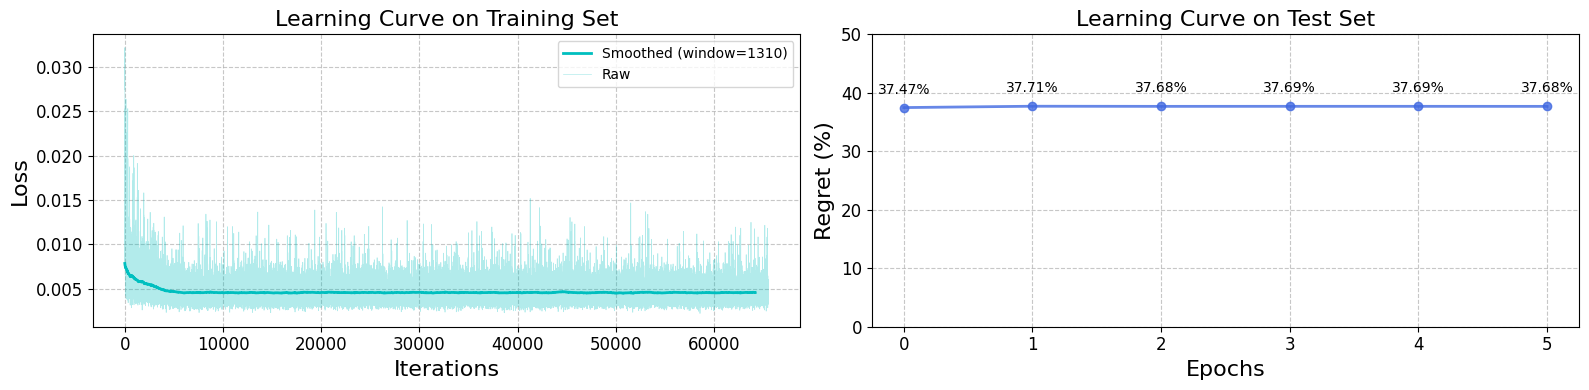

In [7]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt
import numpy as np


def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)

### 回测

In [9]:
lstm_eval = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
checkpoint = torch.load(lstm_save_path, map_location=DEVICE, weights_only=False)
lstm_eval.load_state_dict(checkpoint['model_state_dict'])
print("Model architecture after training:")
for name, param in lstm_eval.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture after training:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: 0.06545653939247131 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: -0.006945034489035606 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.15406328439712524 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.15134763717651367 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([64]) | 

In [10]:
# set lstm to evaluation mode
lstm_eval.eval()

pred_returns = [] # predicted returns
with torch.no_grad():
    for x, _, _, _ in loader_test:
        # 1. 预测 returns
        x = x.to(DEVICE)                      # (batch_size, N, lookback, k)
        pred_return = lstm_eval(x)                   # (batch_size, N)
        pred_return = pred_return.cpu().numpy()             # 转成ndarray
        pred_returns.append(pred_return)

pred_returns = np.vstack(pred_returns) # (T, N)
print(f"预测的收益率矩阵形状是: {pred_returns.shape}")

预测的收益率矩阵形状是: (26202, 13)


#############################################################################
### TODO: 修改RISK_F，增加features(对应修改X_COLS)
#############################################################################

In [23]:
from io_utils import load_optData
from config import OPTDATA_NAME, OPTDATA_DIR
optData = load_optData(OPTDATA_NAME, OPTDATA_DIR)
features = optData[0]
feats_test = features[test_indices]
print(f"测试集feature的形状是: {feats_test.shape}")

Loaded data from ./data with name 'crypto_data'
Features shape: (131010, 13, 6)
Feature names: ['open', 'high', 'low', 'close', 'volume', 'count']
测试集feature的形状是: (26202, 13, 6)


In [24]:
### 优化器
from config import PRECOMPUTE_BATCH_SIZE, LOOKBACK, PADDING_METHOD
from batch_runner import process_and_combine_shared
optModel_test = build_market_neutral_model(N, A, b, l, u, RISK_F, RISK_ABS, SINGLE_ABS, L1_ABS, COV_MATRIX, SIGMA_ABS)
dataset_dict_test = process_and_combine_shared(feats_test, pred_returns, batch_size=PRECOMPUTE_BATCH_SIZE, lookback=LOOKBACK, padding_method=PADDING_METHOD)



 共享内存子进程处理样本 0 到 499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2171.61it/s]



 共享内存子进程处理样本 500 到 999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2298.12it/s]



 共享内存子进程处理样本 1000 到 1499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2239.45it/s]



 共享内存子进程处理样本 1500 到 1999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2276.28it/s]



 共享内存子进程处理样本 2000 到 2499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2284.09it/s]



 共享内存子进程处理样本 2500 到 2999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2182.03it/s]



 共享内存子进程处理样本 3000 到 3499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2267.46it/s]



 共享内存子进程处理样本 3500 到 3999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2357.98it/s]



 共享内存子进程处理样本 4000 到 4499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2322.73it/s]



 共享内存子进程处理样本 4500 到 4999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2222.48it/s]



 共享内存子进程处理样本 5000 到 5499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2288.41it/s]



 共享内存子进程处理样本 5500 到 5999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2307.87it/s]



 共享内存子进程处理样本 6000 到 6499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2317.39it/s]



 共享内存子进程处理样本 6500 到 6999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2251.02it/s]



 共享内存子进程处理样本 7000 到 7499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2337.61it/s]



 共享内存子进程处理样本 7500 到 7999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2354.22it/s]



 共享内存子进程处理样本 8000 到 8499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2319.21it/s]



 共享内存子进程处理样本 8500 到 8999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2291.71it/s]



 共享内存子进程处理样本 9000 到 9499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2261.80it/s]



 共享内存子进程处理样本 9500 到 9999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2256.94it/s]



 共享内存子进程处理样本 10000 到 10499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2189.20it/s]



 共享内存子进程处理样本 10500 到 10999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2213.49it/s]



 共享内存子进程处理样本 11000 到 11499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2275.60it/s]



 共享内存子进程处理样本 11500 到 11999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2221.74it/s]



 共享内存子进程处理样本 12000 到 12499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2212.35it/s]



 共享内存子进程处理样本 12500 到 12999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2286.52it/s]



 共享内存子进程处理样本 13000 到 13499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2247.78it/s]



 共享内存子进程处理样本 13500 到 13999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2282.57it/s]



 共享内存子进程处理样本 14000 到 14499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2304.78it/s]



 共享内存子进程处理样本 14500 到 14999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2279.22it/s]



 共享内存子进程处理样本 15000 到 15499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2340.68it/s]



 共享内存子进程处理样本 15500 到 15999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2328.92it/s]



 共享内存子进程处理样本 16000 到 16499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2241.60it/s]



 共享内存子进程处理样本 16500 到 16999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2286.50it/s]



 共享内存子进程处理样本 17000 到 17499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2294.35it/s]



 共享内存子进程处理样本 17500 到 17999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2313.34it/s]



 共享内存子进程处理样本 18000 到 18499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2145.77it/s]



 共享内存子进程处理样本 18500 到 18999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2221.01it/s]



 共享内存子进程处理样本 19000 到 19499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2313.13it/s]



 共享内存子进程处理样本 19500 到 19999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2189.57it/s]



 共享内存子进程处理样本 20000 到 20499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2075.27it/s]



 共享内存子进程处理样本 20500 到 20999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2328.82it/s]



 共享内存子进程处理样本 21000 到 21499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2284.21it/s]



 共享内存子进程处理样本 21500 到 21999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2288.05it/s]



 共享内存子进程处理样本 22000 到 22499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2368.32it/s]



 共享内存子进程处理样本 22500 到 22999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2286.53it/s]



 共享内存子进程处理样本 23000 到 23499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2240.10it/s]



 共享内存子进程处理样本 23500 到 23999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2325.40it/s]



 共享内存子进程处理样本 24000 到 24499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2265.53it/s]



 共享内存子进程处理样本 24500 到 24999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2272.80it/s]



 共享内存子进程处理样本 25000 到 25499...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2291.57it/s]



 共享内存子进程处理样本 25500 到 25999...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 2310.11it/s]



 共享内存子进程处理样本 26000 到 26201...
Restricted license - for non-production use only - expires 2026-11-23

Optimizing for optDataset...


100%|██████████| 202/202 [00:00<00:00, 2142.85it/s]



 合并所有批次...


In [27]:
# 测试集仓位
positions = dataset_dict_test["sols"]
print(f"测试集仓位的形状是: {positions.shape}")

测试集仓位的形状是: (26202, 13)


In [34]:
pnl_series = []
for i, t in enumerate(test_indices):
    pnl = np.nansum(positions[i] * dataset_dict["costs"][t])
    pnl_series.append(pnl)
print(f"pnl series的长度是: {len(pnl_series)}")

pnl series的长度是: 26202


### Visualize Cumulative Pnl

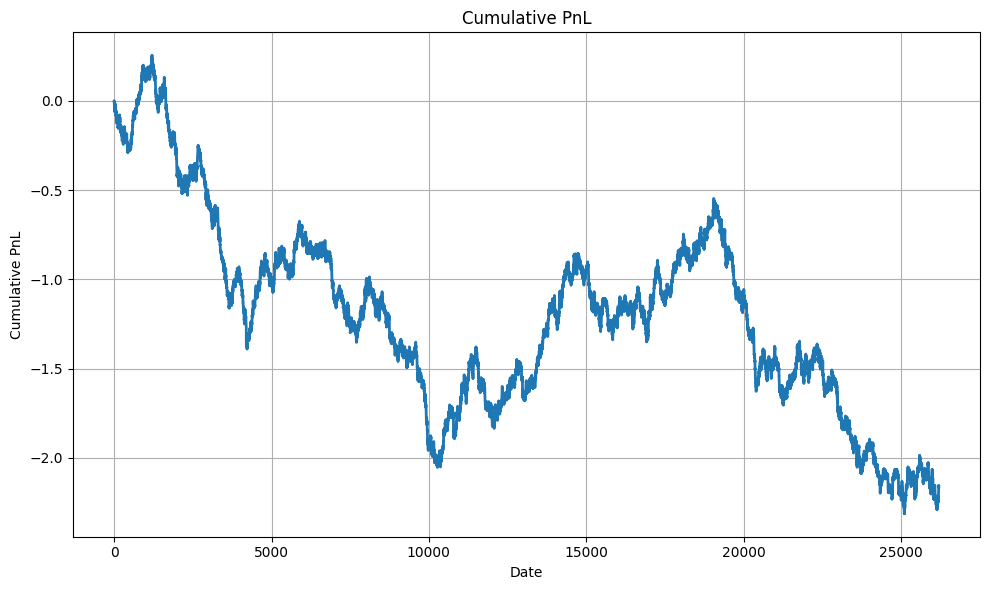

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cum_pnl_series(pnl_series, title='Cumulative PnL', figsize=(10, 6)):
    """
    绘制累计 PnL 曲线。

    参数
    -----
    pnl_series : pandas.Series
        每期的 PnL 序列，索引为日期或时间点。
    title : str, optional
        图表标题，默认 'Cumulative PnL'。
    figsize : tuple, optional
        图表大小，默认为 (10, 6)。
    """
    # 计算累计 PnL
    cum_pnl = pd.Series(pnl_series).cumsum()

    # 绘图
    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(cum_pnl)), cum_pnl.values, linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cum_pnl_series(pnl_series)
